<img src=images/Stöwer_Titanic.jpg align="right" width="15%" style="margin-right:10%">

#### August 18, 2016 - Women in Data Science ATX Meetup - "Data Science from Scratch" Workshop #6

# Hypothesis Testing on the Titanic Data Set with R

## 0. Preliminaries

### 0.1 Setting Up the R Language Kernel For Jupyter
https://www.continuum.io/blog/developer/jupyter-and-conda-r

#### Assumption:
You have Anaconda installed. If not, go here for instructions:  
https://github.com/mGalarnyk/Installations_Mac_Ubuntu_Windows

#### Summary:
1. Open a shell and run this command to install `r-essentials` into the current environment:
<pre><code>conda install -c r r-essentials
</code></pre>
OR, run this command to install it into a new environment:
<pre><code>`conda create -n my-r-env -c r r-essentials`
</code></pre>
2. Start a new jupyter notebook session:
<pre><code>`jupyter notebook`</code></pre>

#### Note:
Beware that you may see traceback (error) messages that print one character per line, i.e., vertically. It looks like this bug has been fixed:  
https://github.com/IRkernel/IRkernel/issues/261

However, the date on the fix is later than the date of the latest release, IRkernel 0.6.1, so we'll just live with it for now:  
https://github.com/IRkernel/IRkernel/releases

In [32]:
# Load libraries
library(ggplot2)
library(dplyr)
library(repr)   

# Change figure size to 6 x 4
options(repr.plot.width=6, repr.plot.height=4)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



### 0.2 Resources:
- *(DS From Scratch)* [Data Science From Scratch](http://shop.oreilly.com/product/0636920033400.do) - Chapter 7: Hypothesis and Inference
- *(IS)* "Inferential Statistics" course: https://www.coursera.org/learn/inferential-statistics-intro/
- *(OIS)* "OpenIntro Statistics" book: https://www.openintro.org/stat/textbook.php?stat_book=os - Chapter 4: Foundations for Inference
- *(PPA)* "Practical Predictive Analytics: Models and Methods" course: (https://www.coursera.org/learn/predictive-analytics/home/week/1) - Week 1: Practical Statistical Inference  
- *(Wikipedia)*: https://en.wikipedia.org/wiki/Statistical_hypothesis_testing
- http://gchang.people.ysu.edu/class/s5817/L/ReviewNote_5817.pdf
- https://www.encyclopedia-titanica.org/
- https://en.wikipedia.org/wiki/Resampling_(statistics)
- https://lagunita.stanford.edu/courses/HumanitiesScience/StatLearning - Chapter 5: Resampling Methods
- http://www.nature.com/news/scientific-method-statistical-errors-1.14700
- https://ds8.gitbooks.io/textbook/content/chapter5/intro.html
- [Statistics for Hackers](https://www.youtube.com/watch?v=Iq9DzN6mvYA) - PyCon 2016 talk by Jake Vanderplas

Some code taken directly from:
- https://www.analyticsvidhya.com/blog/2015/10/inferential-descriptive-statistics-beginners-r/
- https://choens.github.io/titanic-workshop/03-eda-and-hypothesis-testing.html
- https://rpubs.com/jeffrey6557/52266

The files `train.csv` and `test.csv` were downloaded from https://www.kaggle.com/c/titanic/data.

### 0.3 Overview
Our goal in this workshop is to work through a couple of hypothesis tests on the same Titanic dataset that we've worked with in previous workshops. The Titanic data has already been randomly sampled into two files `train.csv` and `test.csv`. However, the file `test.csv` is unlabeled, so we won't use it unless we want to look at distributions of features over the entire set of passenger data. We will use `test.csv` as our *sample* from the *population* of all Titanic passengers (not including crew members).

We'll follow the set of steps for statistical hypothesis testing outlined in the Wikipedia article on this topic. This should help to internalize the process of setting up and performing hypothesis tests.

## 1. State the null and alternative hypotheses
"The first step is to state the relevant null and alternative hypotheses. This is important, as mis-stating the hypotheses will muddy the rest of the process." - *Wikipedia*

Examples of some general hypotheses:
- "This coin is fair."
- "Data scientists prefer Python to R."
- "People are more likely to navigate away from the page without ever reading the content if we pop up an irritating interstitial advertisement with a tiny, hard-to-find close button."

\- *DS From Scratch*

Express the hypothesis you want to investigate as:
- a **null hypothesis** $H_0$ that represents some default position, and
- an **alternative hypothesis** $H_A$ that we'll compare $H_0$ with.

Another way to think of this is that we want to compare an experimental group and a control group. Stated this way:
- the **null hypothesis** claims that there is no difference between the groups, and
- the **alternative hypothesis** claims that there is a statistically significant difference between the groups.

### 1.1 *Example:* Consider `Age` variable
We want to check the significance of the variable `Age` for hypothesis testing. Let's assume that children have a better chance of survival than adults.
- $H_0$: There is no significant difference in the chances of survival of children and adults.
- $H_A$: There is a better chance of survival for children.

### 1.2 *Exercise:* Consider `Pclass` (passenger class) variable
- $H_0$: There is no significant difference in the chances of survival of upper and lower class passengers.
- $H_A$: There is a better chance of survival for upper class passengers. 

If you need ideas, check this blog post:
https://www.analyticsvidhya.com/blog/2015/10/inferential-descriptive-statistics-beginners-r/

Below we will define "significant difference" and use statistics to decide whether we can reject the null hypothesis ($H_0$) or not. 

## 2. Discuss Titanic data collection
"The second step is to consider the statistical assumptions being made about the sample in doing the test; for example, assumptions about the statistical independence or about the form of the distributions of the observations. This is equally important as invalid assumptions will mean that the results of the test are invalid." - *Wikipedia*

In hypothesis testing the "control" and "experimental" groups are typically defined through careful experimental design. This is not usually the case in data science applications, though. An exception is collecting click-through data in an A/B test that measures the effect of new ad placement on your website compared to the control group, or existing placement. - *PPA*

#### Let's consider the Titanic data set:

In [47]:
train <- read.csv("data/train.csv")  # read in Titanic training data csv file to R data frame
str(train)                           # display data frame using R `str` function

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


The training data is a sample of 891 passengers from the population size of the approximate [1317 total passengers](http://www.titanicfacts.net/titanic-passengers.html) on board who paid a fare (i.e., not crew members). This is over 67% of all fare-paying passengers aboard the Titanic when it sank. 

There are 12 columns, but we will look at just a few:
- 1 numerical: age
- 3 categorial/logical: passenger class, sex, survival

In [48]:
train <- data.frame(train$Survived, train$Age, train$Sex, train$Pclass); 
names(train) <- c("Survived", "Age", "Sex","Pclass"); # rename columns and 
head(train) # display first 6 rows of data frame

,Survived,Age,Sex,Pclass
1,0,22,male,3
2,1,38,female,1
3,1,26,female,3
4,1,35,female,1
5,0,35,male,3
6,0,NA,male,3


In [46]:
# # UNCOMMENT TO LOOK AT FULL SET OF DATA (WITHOUT SURVIVAL LABELS)
# test  <- read.csv('data/test.csv')   # read in Titanic test data csv file

# Look at just Age, Sex and Pclass, and disclude Survived since the training data is unlabeled
# train <- data.frame(train$Age, train$Sex, train$Pclass);  
# test  <- data.frame(test$Age, test$Sex, test$Pclass);
# names(train) <- c("Age", "Sex","Pclass"); # rename column variables
# names(test)  <- c("Age", "Sex","Pclass");

# full  <- bind_rows(train, test)      # bind training & test data
# str(full)                           

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1309 obs. of  3 variables:
 $ Age   : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ Sex   : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Pclass: int  3 1 3 1 3 3 1 3 3 2 ...


The training data set contains age data on ~80% of the passengers in this sample (714 / 891):

In [55]:
str(train[!is.na(train$Age),])

'data.frame':	714 obs. of  4 variables:
 $ Survived: int  0 1 1 1 0 0 0 1 1 1 ...
 $ Age     : num  22 38 26 35 35 54 2 27 14 4 ...
 $ Sex     : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 1 1 1 ...
 $ Pclass  : int  3 1 3 1 3 1 3 3 2 3 ...


#### Let's drop rows without Age values:

In [50]:
train_age <- train[!is.na(train$Age),] # strip data of rows with Age=NULL
summary(train_age$Age)                 # show some descriptive statistics of Age variable

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.42   20.12   28.00   29.70   38.00   80.00 

This reduces our sample size to 714 observations, a little over 54% (714 / 1317) of the population. This may reduce the randomness of our sample since passengers missing age data may not have been randomly selected for discluding this information.

The youngest passenger in this sample was 5 months old and the oldest was 80 years old, which seems quite a bit older than the average life expectancy of early to mid 50s for the year 1912 when the Titanic sank: http://demog.berkeley.edu/~andrew/1918/figure2.html

#### Let's take a look at the distribution of passenger ages:

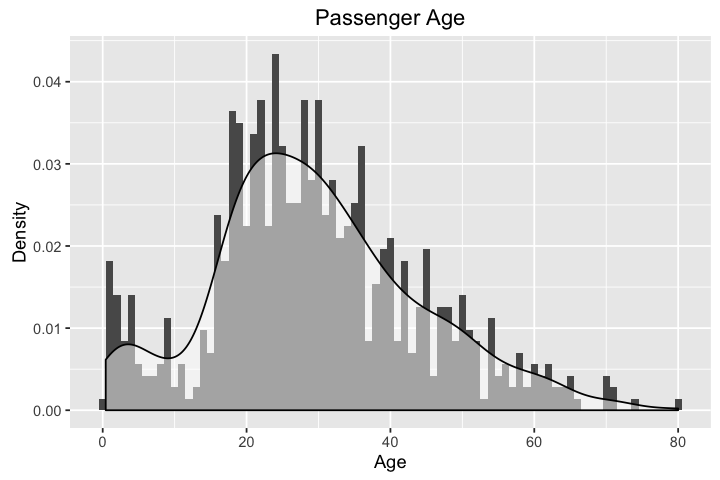

In [52]:
# Overlay a probability distribution function (PDF) on a histogram of Age
ggplot(train_age, aes(x=Age)) + 
    ggtitle("Passenger Age") + 
    xlab("Age") + 
    ylab("Density") + 
    geom_histogram(aes(y=..density..), binwidth=1)+
    geom_density(alpha=.5, fill="#FFFFFF")

We can see the discrepancies at extreme ages with a normal quantile plot. The data is noticeably right-skewed, although there is clear dip in the number of pre-teen and teenage passengers. 

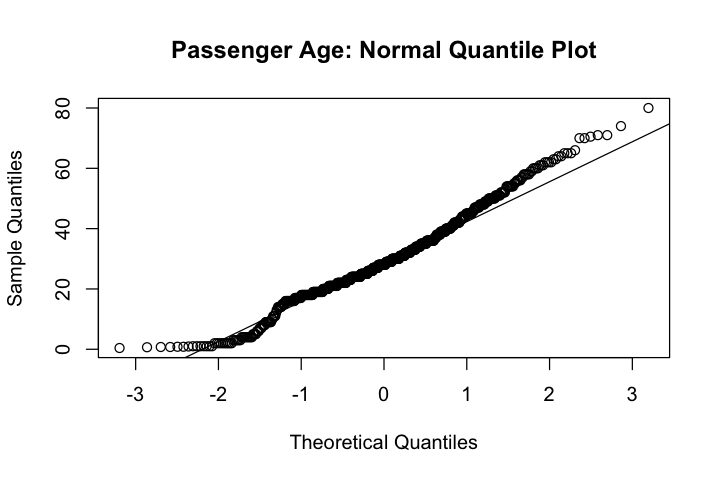

In [53]:
qqnorm(train_age$Age, main="Passenger Age: Normal Quantile Plot")
qqline(train_age$Age)

Now let's discretize the ages into two groups - adults and children. We'll choose 18 years old as the minimum age for an adult. There are 113 children in the data set:

In [54]:
length(which(train_age$Age < 18))

[1] 113

In [57]:
# Add a new categorical variable called "age_group" for child/adult.
train_age$age_group <- "adult"
train_age$age_group[train_age$Age < 18] <- "child"

#### Let's display a contingency table of child/adult survival:
We see that 54% of children and only 38% of adults survive. But the child population is much smaller than the adult one. 

In [58]:
age_group.Survived <- table(train_age$age_group, train_age$Survived); age_group.Survived

       
          0   1
  adult 372 229
  child  52  61

In [59]:
age_group_survived.prop <- prop.table(age_group.Survived, 1); age_group_survived.prop

       
                0         1
  adult 0.6189684 0.3810316
  child 0.4601770 0.5398230

## 3. Decide on test and test statistic
"Decide which test is appropriate, and state the relevant test statistic T." - *Wikipedia*

## 4. Calculate the test statistic from the data
"Compute from the observations the observed value $t_\rm{obs}$ of the test statistic $T$." - *Wikipedia*

#### Is the difference in survival rates significant? Let's see with a permutation test:

In [60]:
adult_survived <- age_group_survived.prop[3]
child_survived <- age_group_survived.prop[4]
observed <-  child_survived / adult_survived; observed # children are nearly 1.42x more likely to survive 

[1] 1.416741

In [61]:
N=10^4-1 ; result <- numeric(N)  
for (i in 1:N) {
    index <- sample(nrow(train), size=154, replace=FALSE)
    child_sample <- length(which(train$Survived[index] == 1)) / length(index)
    adult_sample <- length(which(train$Survived[-index] == 1)) / (nrow(train) - length(index))
    result[i] <- child_sample / adult_sample 
}

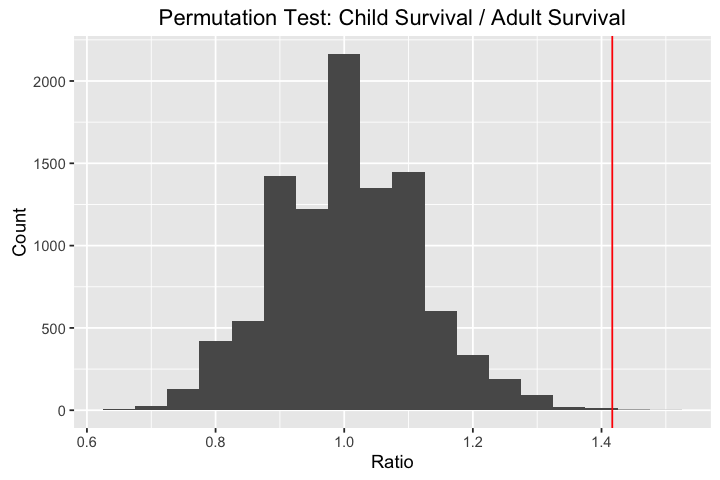

In [62]:
qplot(result, binwidth=.05) + 
    geom_vline(xintercept = observed, color="red") +#, label="Observed") +
    ggtitle("Permutation Test: Child Survival / Adult Survival") + 
    xlab("Ratio") + 
    ylab("Count")

## 5. Calculate the $p$-value
"Calculate the `p`-value. This is the probability, under the null hypothesis, of sampling a test statistic at least as extreme as that which was observed." - *Wikipedia*

In [63]:
pvalue = (sum (result >= observed) + 1)/(N+1); 2*pvalue 

[1] 0.001

## 6. Should we reject the null hypothesis?
"Reject the null hypothesis, in favor of the alternative hypothesis, if and only if the `p`-value is less than the significance level (the selected probability) threshold." - *Wikipedia*

A near-zero p-value indicates that the evidence supports the hypothesis that children are more likely to have survived.

So, we should **reject** the null hypothesis.

|                    | Do Not Reject $H_0$                   | Reject $H_0$                         |
|--------------------|:-------------------------------------:|:------------------------------------:|
| **$H_0$ is True**  | *Correct Decision*<br>($1 - \alpha$)  | *Type 1 Error*<br>($\alpha$)         |
| **$H_0$ is False** | *Type 2 Error*<br> ($\beta)$          | *Correct Decision*<br> ($1 - \beta)$ |

## EXERCISE TIME!
Now try working through hypothesis testing on `Pclass` or `Sex`!

## Final Comments


"To do good *science*:"
>- Determine your hypotheses before looking at the data.
>- Clean your data without the hypotheses in mind.
>- Keep in mind that $p$-values are not substitutes for common sense.

- *DS From Scratch*